In [338]:
using Revise, Statistics, LaTeXStrings, DSP, StatsBase
using Formatting, MAT, FFTW, Unitful, LinearAlgebra, WAV
import Unitful: m, s, Hz, AbstractQuantity
using CairoMakie, Makie
using ColorSchemes
import ColorSchemes: nord, tab10, Dark2_8

printx(x,N) = sprintf1("%.$(N)f",x)
toUnit(unit) = x -> uconvert(unit, x)



fg = :black; gg = :grey; cscheme = tab10; bg = :white
# fg = nord[5]; gg = nord[3]; cscheme = Dark2_8; bg = :transparent


set_theme!(Theme(
    fontsize = 20,
    palette = ( color = cscheme,),
    Axis = (
        backgroundcolor = bg,
        xtickcolor = fg, ytickcolor = fg,
        xgridcolor = gg, ygridcolor = gg,
        xlabelcolor = fg, ylabelcolor = fg,
        xticklabelcolor = fg, yticklabelcolor = fg,
        topspinecolor = fg, bottomspinecolor = fg,
        leftspinecolor = fg, rightspinecolor = fg,
        titlecolor = fg,
    ),
    Legend = (
        bgcolor = bg,
        labelcolor = fg, titlecolor = fg,
        framevisible = false, margin=(0,0,0,0)
    ),
    Colorbar = (
        labelcolor = fg, titlecolor = fg,
        ticklabelcolor = fg, tickcolor = fg,
        topspinecolor = fg, bottomspinecolor = fg,
        leftspinecolor = fg, rightspinecolor = fg,
    )
))

In [2]:
Makie.convert_single_argument(x::AbstractArray{<: AbstractQuantity}) = ustrip.(x)

In [123]:
function convm(x,p)
    N = length(x) + 2*p - 2
    x = x[:]
    xpad = vcat(zeros(p-1,1), x, zeros(p-1,1))
    X = Array{Float64, 2}(undef, length(x)+p-1, p)
    for i = 1:p
        X[:, i] = xpad[p-i+1:N-i+1]
    end
    return X
end



convm (generic function with 1 method)

In [38]:
y, fs = wavread("notch1-a.wav")

([0.34901960784313735; 0.28627450980392166; … ; -0.050980392156862786; -0.0117647058823529;;], 8000.0f0, 0x0008, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x01, 0x00, 0x40, 0x1f, 0x00, 0x00, 0x40, 0x1f, 0x00, 0x00, 0x01, 0x00, 0x08, 0x00])])

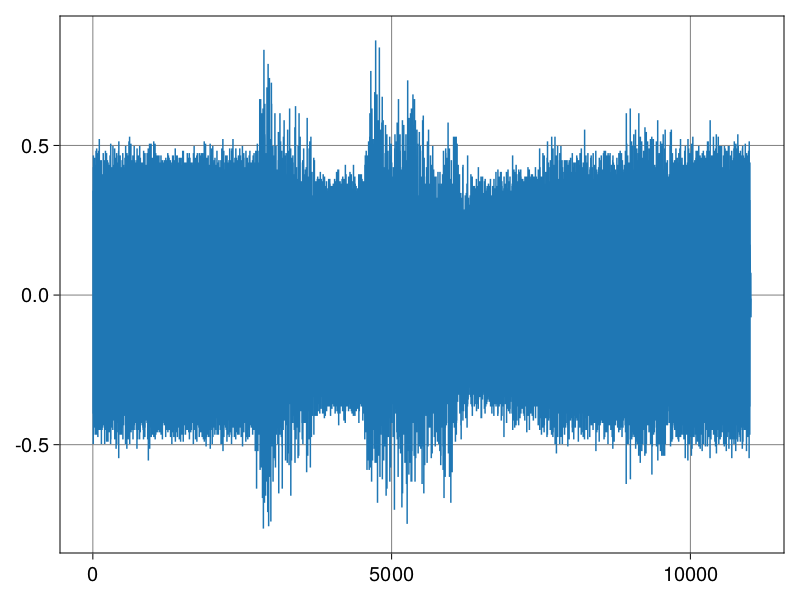

In [45]:
y = vec(y)
wavplay(y, fs)
lines(y)

Y.freq[argmax(Y.power)] = 0.2721995464852608


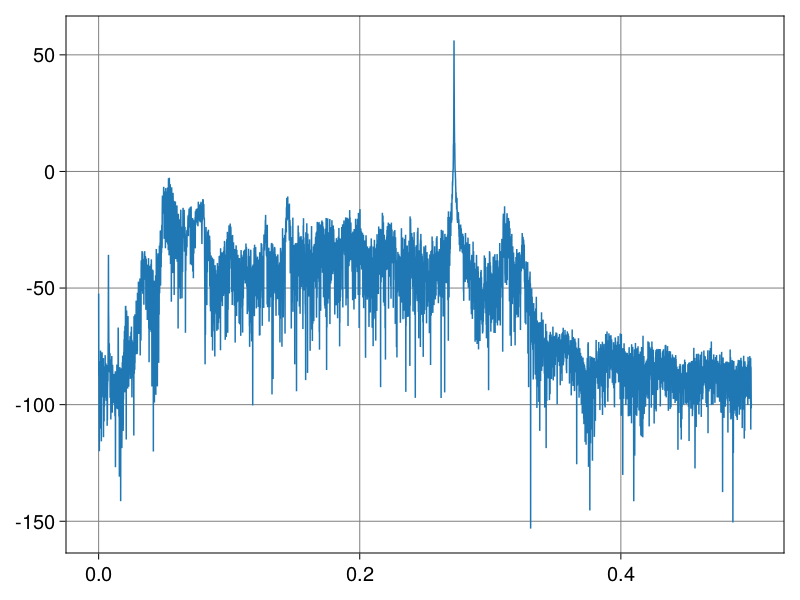

In [58]:
Y = periodogram(y)
@show Y.freq[argmax(Y.power)]
lines(Y.freq, Y.power .|> amp2db)

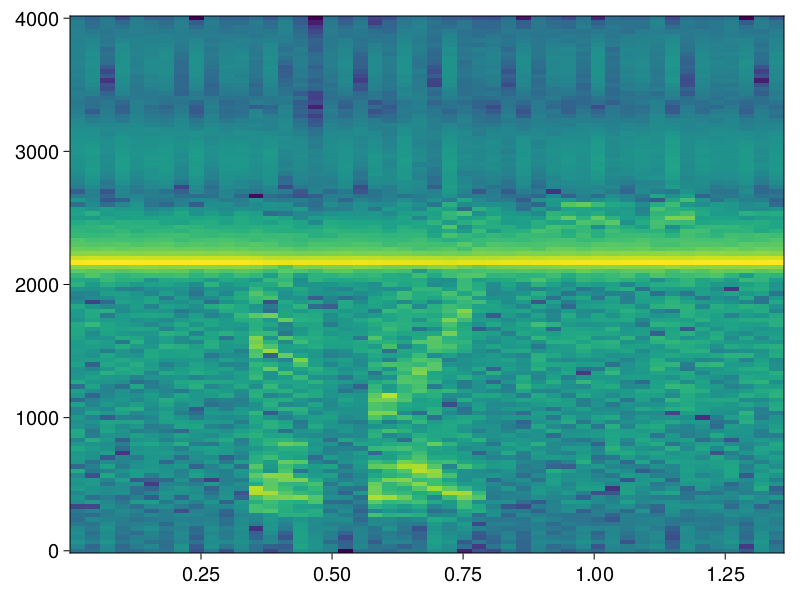

In [302]:
function lms(x,d,mu,nord;a0 = missing)
    X=convm(x,nord);
    
    M,N = size(X)
    if ismissing(a0)
        a0 = zeros(1,N)
    end
    
    A = zeros(M-nord+1, N)
    E = zeros(M-nord+1)

    E[1] = d[1] - (a0*X[1,:])[1]
    # println("$(size(a0))+$(size(mu))*$(size(E[1]))*$(size(conj(X[1,:]')))")
    A[1,:] = a0 + mu*E[1]*X[1,:]'
    if M > 1
        for k=2:M-nord+1
            # println("$(size(d[k]))-$(size(A[k-1,:]))*$(size(X[k,:]))")
            E[k] = d[k] - A[k-1,:]'*X[k,:]
            A[k,:] = A[k-1,:] + mu*E[k]*conj(X[k,:])
        end
    end
    return A,E
end

lms (generic function with 1 method)

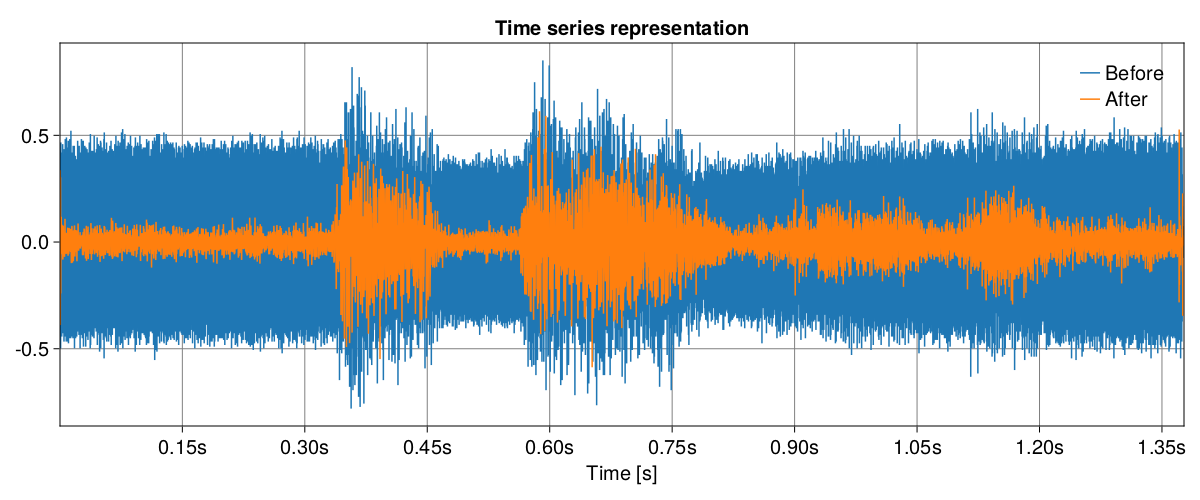

CairoMakie.Screen{IMAGE}


In [377]:
lag_M_idx = convert(Int, ceil(3.9/1000 * fs))

y_ref = [y[lag_M_idx+1:end]; zeros(lag_M_idx)]

A,E = lms(y, y_ref, 0.5, 7);
F = Figure(resolution=(1200,500))
ax = Axis(F[1,1], title="Time series representation", xlabel="Time [s]", xticks=MultiplesTicks(11,1,"s"))
t = (1:length(y))./fs
lines!(t, y, label="Before")
lines!(t, E, label="After")
xlims!(minimum(t), maximum(t))
axislegend(ax)
display(F)
# wavplay(E,fs)

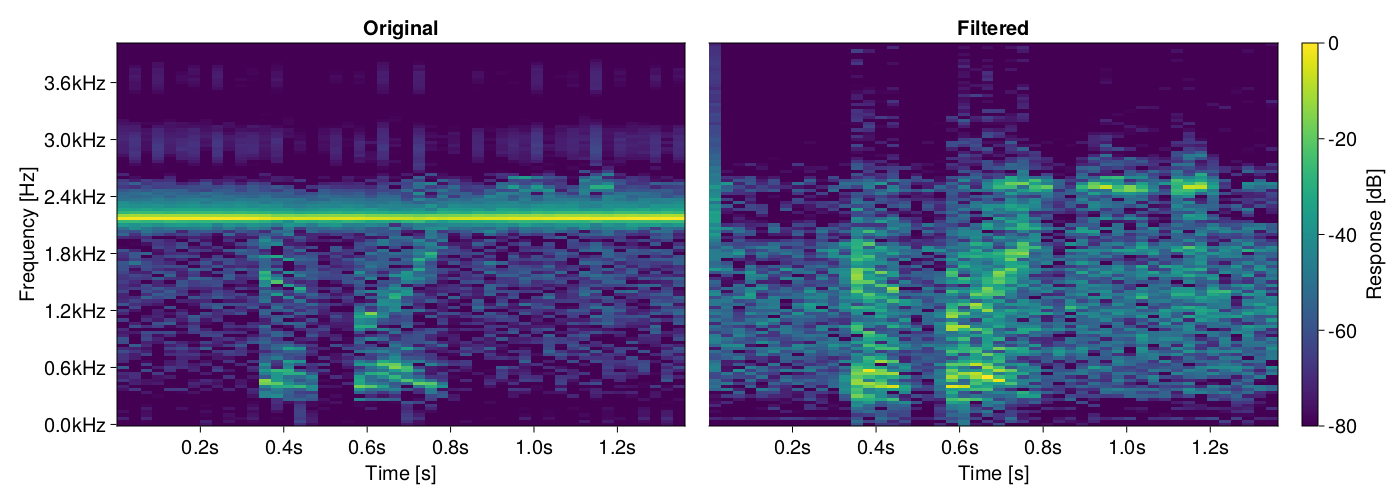

In [378]:
E_s = spectrogram(E,length(E)÷48,2, fs=fs)
Y_s   = spectrogram(y,length(y)÷48,2, fs=fs)
c_r = (-80, 0)
F = Figure(backgroundcolor=bg, resolution=(1400,500))
ax = Axis(F[1,1], xlabel="Time [s]", ylabel="Frequency [Hz]", yticks=MultiplesTicks(7,1000,"kHz"), xticks=MultiplesTicks(7,1,"s"), title="Original")
ax2 = Axis(F[1,2], xlabel="Time [s]", xticks=MultiplesTicks(7,1,"s"), title="Filtered", leftspinevisible=false, yticksvisible=false, yticklabelsvisible=false)
linkyaxes!(ax,ax2)
hm = heatmap!(ax ,time(Y_s), freq(Y_s), amp2db.(abs.(power(Y_s)')./maximum(abs.(power(Y_s)'))), colorrange=c_r)
hm = heatmap!(ax2,time(E_s), freq(E_s), amp2db.(abs.(power(E_s)')./maximum(abs.(power(E_s)'))), colorrange=c_r)
Colorbar(F[1,3], hm, label="Response [dB]")
F